# Phishing URL Dataset Analysis

In [38]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve
)
import joblib

### Load the precomputed dataset

In [30]:
ls

Analysis.ipynb             phishing_analysis.ipynb
SimpleExtension/           trainer.py
phishing_analysis 2.ipynb


In [34]:
df = pd.read_csv("SimpleExtension/datasets/features.csv")
X = df.drop(["label","url"], axis=1)
y = df["label"]

In [35]:
df

,url_length,dot_count,has_at,special_char_count,entropy,suspicious_keywords,subdomain_length,is_free_hosting,has_hyphen,is_ip,...,xhrCount,wsCount,scriptInjectionCount,eventListenerCount,domMutationCount,attributeMutationCount,pageLoadTime,cpuTime,memoryUsed,label
0,18,1,0,0,2.646439,0,0,0,0,0,...,2,0,2,98,0,0,1477,6057,10000000,0
1,21,1,0,0,3.026987,0,0,0,0,0,...,0,0,3,105,39,0,1687,6971,17100000,0
2,15,1,0,0,2.807355,0,0,0,0,0,...,2,0,4,62,1,0,4071,7681,10600000,0
3,20,1,0,0,3.022055,0,0,0,0,0,...,0,0,0,2,0,0,1179,6157,2204873,0
4,15,1,0,0,2.807355,0,0,0,0,0,...,6,0,4,57,1,1,4407,6045,21700000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,20,1,0,0,3.188722,0,0,1,0,0,...,0,0,0,20,0,0,1569,6560,10000000,0
63,17,1,0,0,2.947703,0,0,0,0,0,...,2,0,10,20,5,0,2136,6919,11900000,0
64,25,1,0,0,3.381580,0,0,0,0,0,...,0,0,0,0,0,0,691,6217,10000000,0
65,26,1,0,1,3.725481,0,0,0,1,0,...,0,0,0,12,0,1,751,6186,10000000,0


### 1. Optimize n_estimators via OOB error

In [36]:
tree_range = list(range(10, 301, 10))
oob_errors = []
for n in tree_range:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X, y)
    oob_errors.append(1 - rf.oob_score_)

In [44]:
# verify labels
print(y.value_counts())


label
0    67
Name: count, dtype: int64


draw the data

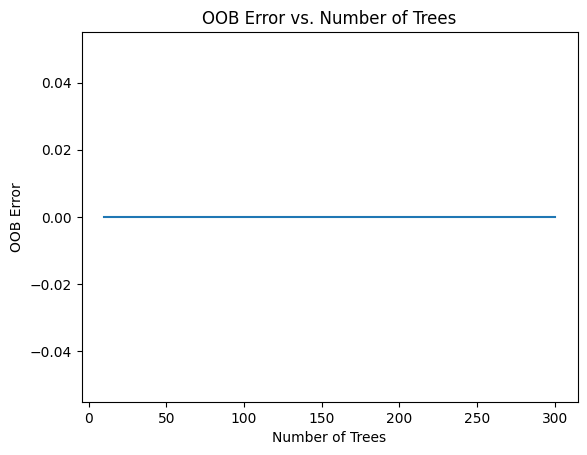

In [39]:
plt.figure()
plt.plot(tree_range, oob_errors)
plt.title("OOB Error vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.show()

In [40]:
best_n = tree_range[np.argmin(oob_errors)]

In [41]:
best_n

10

### 2. Feature importances

In [42]:
rf_sel = RandomForestClassifier(n_estimators=best_n, n_jobs=-1, random_state=42)
rf_sel.fit(X, y)
importances = rf_sel.feature_importances_
indices = np.argsort(importances)[::-1]


draw the data

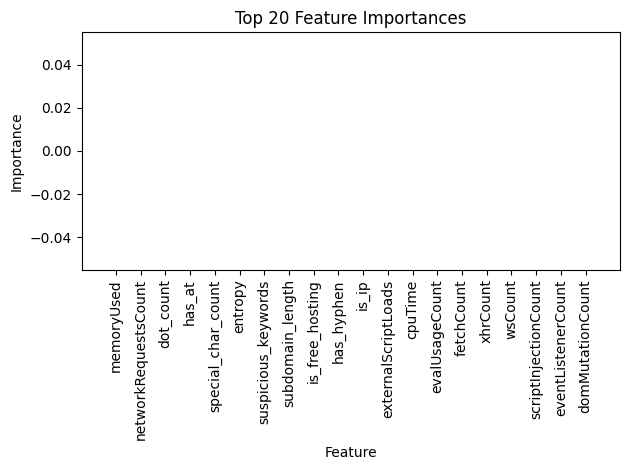

In [45]:
top_n = 20
plt.figure()
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=90)
plt.title("Top 20 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 3. MAE vs number of selected features

In [46]:
mae_scores = []
ks = list(range(1, len(X.columns) + 1))
for k in ks:
    sel = [X.columns[i] for i in indices[:k]]
    scores = -cross_val_score(
        RandomForestClassifier(n_estimators=100, random_state=42),
        X[sel], y,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    mae_scores.append(scores.mean())

draw the data

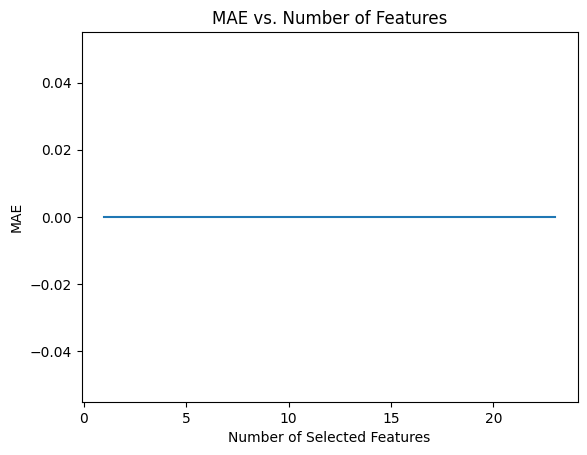

In [47]:
plt.figure()
plt.plot(ks, mae_scores)
plt.title("MAE vs. Number of Features")
plt.xlabel("Number of Selected Features")
plt.ylabel("MAE")
plt.show()

In [48]:
best_k = ks[np.argmin(mae_scores)]
selected_features = [X.columns[i] for i in indices[:best_k]]
X_sel = X[selected_features]

In [49]:
print("selected_features: ", selected_features)

selected_features:  ['memoryUsed']


### 4. ROC curve and threshold selection

In [50]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_val_probs = []
all_val_labels = []

In [51]:
for train_idx, val_idx in skf.split(X_sel, y):
    m = RandomForestClassifier(n_estimators=100, random_state=42)
    m.fit(X_sel.iloc[train_idx], y.iloc[train_idx])
    probs = m.predict_proba(X_sel.iloc[val_idx])[:, 1]
    all_val_probs.extend(probs)
    all_val_labels.extend(y.iloc[val_idx])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
all_val_probs = np.array(all_val_probs)
all_val_labels = np.array(all_val_labels)

In [ ]:
fpr_arr, tpr_arr, thr_arr = roc_curve(all_val_labels, all_val_probs)
j_scores = tpr_arr - fpr_arr
best_idx = np.argmax(j_scores)
best_threshold = thr_arr[best_idx]

In [ ]:
plt.figure()
plt.plot(fpr_arr, tpr_arr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
print("Optimal threshold: ", best_threshold)

### 5. Final train/test evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42
)

In [ ]:
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

y_probs_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_probs_test >= best_threshold).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

In [ ]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)